## Importing Packages

In [1]:
import torch
import os
import setuptools
import torch.nn as nn
from torch.nn import Linear, Conv2d, CrossEntropyLoss
from torch.optim import AdamW, Adam, SGD, RMSprop
from torch.utils.data import Dataset, DataLoader, TensorDataset, ConcatDataset
from torchvision import transforms
from torchvision.datasets import MNIST
import pytorch_lightning as pl
import numpy as np
from tqdm.autonotebook import tqdm
from sklearn.metrics import classification_report
import warnings
from IPython.display import Image
warnings.filterwarnings(action='once')
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchsummary import summary
from skmultilearn.model_selection import iterative_train_test_split
from pytorch_lightning.loggers import TensorBoardLogger

/Users/snehpandya/venv-ml/lib/python3.8/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(
/Users/snehpandya/venv-ml/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


# Random Intro Stuff

In [2]:
warnings.filterwarnings('ignore')

In [3]:
torch.manual_seed(0)

In [4]:
logger = TensorBoardLogger ('tb_logs', name='my_model_run_ name')

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cpu for inference


In [6]:
# Helper function to subset data
def subset_data(dataset,k): 
    subset = torch.utils.data.Subset(dataset, range(0, int(2**(-k)*(len(dataset)))))
    return subset

# Helper function to see distribution of data subset
def analyze_subset(dataset):
    labels = []
    counts = {}
    for i in range(0,len(dataset)):
        labels.append(dataset[i][1])

    for i in range(0,10):
        counts[i] = labels.count(i)
    plt.bar(counts.keys(), counts.values(), tick_label=range(0,10))
    plt.xlabel('Integers')
    plt.ylabel('Frequency')
    plt.title(f'Total # of Digits: {len(dataset)}')
    
# return number of total trainable parameters for model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# this is a very dirty way of combining the datasets ¯\_(ツ)_/¯
def combine_dataset(train_ds, test_ds):
    transform = transforms.Compose([transforms.ToTensor()])
#     X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(train_ds.data, train_ds.targets, stratify=train_ds.targets)
#     X_train_2, X_test_2, Y_train_2, Y_test_2 = train_test_split(test_ds.data, test_ds.targets, stratify=test_ds.targets)


#     subset_X_train = torch.cat((X_train_1, X_train_2),dim=0)
#     subset_Y_train = torch.cat((Y_train_1, Y_train_2),dim=0)
#     subset_X_test = torch.cat((X_test_1, X_test_2),dim=0)
#     subset_Y_test = torch.cat((Y_test_1, Y_test_2),dim=0)

#     subset_X = torch.cat((subset_X_train, subset_X_test))
#     subset_Y = torch.cat((subset_Y_train, subset_Y_test))

    full_train_ds = ConcatDataset([train_ds, test_ds])
    return full_train_ds

## Downloading MNIST Data

In [7]:
train_ds = MNIST("mnist", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()])) # size = ([60000, 28, 28], [60000])
test_ds = MNIST("mnist", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()])) # size = ([10000, 28, 28], [10000])

## Subsetting Data + Defining Dataloaders

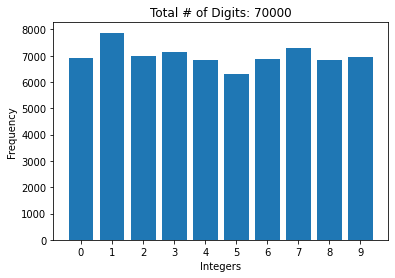

In [8]:
full_train_ds = combine_dataset(train_ds, test_ds)
analyze_subset(full_train_ds)
# analyze_subset(train_ds)
# analyze_subset(test_ds)

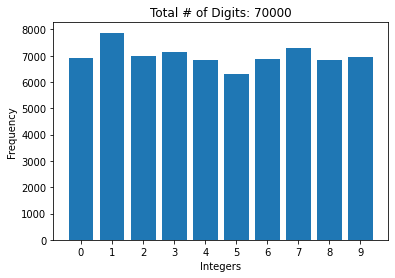

In [9]:
subset_ds = subset_data(full_train_ds,0)
analyze_subset(subset_ds)

In [10]:
train_dl = DataLoader(train_ds, batch_size=16, num_workers=10) # size = 157
full_train_dl = DataLoader(full_train_ds, batch_size=16, num_workers=10) # size = 157
subset_dl = DataLoader(subset_ds, batch_size=16, shuffle=True, num_workers=10)

## Defining ResNets + Training Loops

In [15]:
class ResNet50(pl.LightningModule):
  def __init__(self):
    super().__init__()
    self.model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
    self.model.fc = Linear(in_features=2048, out_features=10)
    self.model.conv1 = Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    self.loss = CrossEntropyLoss()
    self.epoch = self.current_epoch

  def forward(self, x):
    return self.model(x)

  def training_step(self, batch, batch_no):
    x, y = batch
    logits = self(x)
    loss = self.loss(logits, y)
    logs={"train_loss:", loss}
    batch_dictionary={
            "loss": loss,
            "log": logs,
        }
    return batch_dictionary

  def training_epoch_end(self,outputs):
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        self.logger.experiment.add_scalar("Train_Loss/Epoch", avg_loss, self.current_epoch)
        epoch_dictionary={'loss': avg_loss}
#         return epoch_dictionary


  def configure_optimizers(self):
    return SGD(self.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)

In [16]:
model = ResNet50()
summary(model, [(1, 24, 24)])

Using cache found in /Users/snehpandya/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 12, 12]           3,136
       BatchNorm2d-2           [-1, 64, 12, 12]             128
              ReLU-3           [-1, 64, 12, 12]               0
         MaxPool2d-4             [-1, 64, 6, 6]               0
            Conv2d-5             [-1, 64, 6, 6]           4,096
       BatchNorm2d-6             [-1, 64, 6, 6]             128
              ReLU-7             [-1, 64, 6, 6]               0
            Conv2d-8             [-1, 64, 6, 6]          36,864
       BatchNorm2d-9             [-1, 64, 6, 6]             128
             ReLU-10             [-1, 64, 6, 6]               0
           Conv2d-11            [-1, 256, 6, 6]          16,384
      BatchNorm2d-12            [-1, 256, 6, 6]             512
           Conv2d-13            [-1, 256, 6, 6]          16,384
      BatchNorm2d-14            [-1, 25

In [103]:
# for (name, layer) in model._modules.items():
#     print((name, layer))
           
# for name, param in model.named_parameters(): 
#     print(int(.5*param.shape[0]))

In [104]:
# model2 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
# model2.layer1[0].conv1.in_channels
# # model2.fc.in_features

In [105]:
trainer = pl.Trainer(max_epochs=7, logger=logger)
trainer.fit(model, subset_dl)

# with open('test.txt', 'w') as f:
#     f.write(trainer.fit(model, full_train_dl))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name  | Type             | Params
-------------------------------------------
0 | model | ResNet           | 23.5 M
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.089    Total estimated model params size (MB)
/Users/snehpandya/venv-ml/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory tb_logs/my_model_run_ name/version_0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Training: 0it [00:00, ?it/s]

/Users/snehpandya/venv-ml/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
/Users/snehpandya/venv-ml/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
/Users/snehpandya/venv-ml/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
/Users/snehpandya/venv-ml/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
/Users/snehpandya/venv-ml/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
/Users/snehpandya/venv-ml/lib/python3.8/site-packages/t

/Users/snehpandya/venv-ml/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
/Users/snehpandya/venv-ml/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
/Users/snehpandya/venv-ml/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
/Users/snehpandya/venv-ml/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
/Users/snehpandya/venv-ml/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
/Users/snehpandya/venv-ml/lib/python3.8/site-packages/t

In [71]:
print(trainer.callback_metrics)

{'loss:': tensor(1.8945)}


In [132]:
with open('test.txt', 'w') as f:
    save_path = '/Users/snehpandya/Projects/NN Scaling/notebooks/'
    completeName = os.path.join(save_path, 'results.txt')
    f.write(str(trainer.callback_metrics))

In [133]:
trainer.save_checkpoint("resnet50_mnist.pt")

## Testing Model

In [ ]:
def get_prediction(x, model: pl.LightningModule):
  model.freeze() # prepares model for predicting
  probabilities = torch.softmax(model(x), dim=1)
  predicted_class = torch.argmax(probabilities, dim=1)
  return predicted_class, probabilities

inference_model = ResNet50.load_from_checkpoint("resnet50_mnist.pt", map_location=torch.device('cpu'))

In [ ]:
true_y, pred_y = [], []
for batch in tqdm(iter(test_dl), total=len(test_dl)):
  x, y = batch
  true_y.extend(y)
  preds, probs = get_prediction(x, inference_model)
  pred_y.extend(preds.cpu())

In [ ]:
print(classification_report(true_y, pred_y, digits=3))

## Unused Code

In [ ]:
# n_train = 2**(-1)*len(train_ds)
# n_test = 2**(-1)*len(test_ds)
    

# X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(train_ds.data, train_ds.targets, stratify=train_ds.targets, train_size=int(n_train),random_state=1)
# X_train_2, X_test_2, Y_train_2, Y_test_2 = train_test_split(test_ds.data, test_ds.targets, stratify=test_ds.targets, train_size=int(n_test),random_state=1)


# subset_X = torch.cat((X_train_1, X_train_2),dim=0)
# subset_Y = torch.cat((Y_train_1, Y_train_2),dim=0)
# # final_subset = torch.utils.data.ConcatDataset([subset_X, subset_Y], dim=1)


# print(subset_X.shape)
# print(subset_Y.shape)